### This notebook demonstrates the prediction of bathymetry by using random forest model. The data is mosaicked by taking the median of 1 yr long satellite images (from 2020/10). Assuming the water level remains the same all the year.

In [1]:
import rioxarray as rxr

In [2]:
#swanson_da = rxr.open_rasterio('../data/swanson/202010_1yr_median_clipped.tif')
swanson_da = rxr.open_rasterio('202010_1yr_median_clipped.tif')

#### Note: the bands are changed from string to integer

In [3]:
swanson_da

<xarray.DataArray (band: 16, y: 412, x: 793)>
[5227456 values with dtype=float64]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * x            (x) float64 3.165e+05 3.165e+05 ... 3.244e+05 3.244e+05
  * y            (y) float64 4.45e+06 4.45e+06 4.45e+06 ... 4.446e+06 4.446e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     stackstac-2def63b493e1413ae9abc6d4d5850467

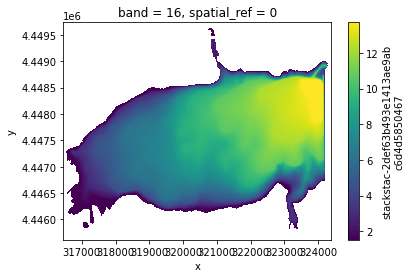

In [4]:
swanson_da.sel(band=16).plot()

In [5]:
swanson_da_numpy = swanson_da.copy().to_numpy()

In [6]:
swanson_da_numpy.shape

(16, 412, 793)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [8]:
rf = RandomForestRegressor(random_state=42)

#### Shuffle the pixels the separate them into train set and test set

In [9]:
lon_indices = list(range(swanson_da_numpy.shape[1]))

In [10]:
lat_indices = list(range(swanson_da_numpy.shape[2]))

In [11]:
train_lon_indices, test_lon_indices = train_test_split(lon_indices, test_size=0.2, random_state=42)

In [12]:
train_lat_indices, test_lat_indices = train_test_split(lat_indices, test_size=0.2, random_state=42)

In [13]:
train = swanson_da_numpy[:,train_lon_indices, :]
train = train[:,:,train_lat_indices]

In [14]:
train.shape

(16, 329, 634)

In [15]:
test = swanson_da_numpy[:,test_lon_indices, :]
test = test[:,:,test_lat_indices]

In [16]:
test.shape

(16, 83, 159)

#### target_train is the depth data for training, target_test is the depth data for testing

In [17]:
target_train = train[15,:,:]
target_test = test[15,:,:]

In [18]:
target_test.shape

(83, 159)

In [19]:
target_train.shape

(329, 634)

In [20]:
train_dropT = train[:15,:,:]
test_dropT = test[:15,:,:]

In [21]:
train_dropT.shape

(15, 329, 634)

In [22]:
target_train.shape

(329, 634)

#### Reshape dimension to 2D due to acceptance of input format of RF model

In [23]:
train_dropT_2D = train_dropT.reshape((train_dropT.shape[0],train_dropT.shape[1]*train_dropT.shape[2]))

In [24]:
target_train_1D = target_train.reshape(target_train.shape[0]*target_train.shape[1])

#### Turn NaN into 0

In [25]:
train_dropT_2D = np.nan_to_num(train_dropT_2D)

In [26]:
target_train_1D = np.nan_to_num(target_train_1D)

In [27]:
train_dropT_2D.transpose().shape

(208586, 15)

In [28]:
target_train_1D.shape

(208586,)

In [29]:
rf_model = rf.fit(train_dropT_2D.transpose(), target_train_1D)

In [30]:
test_dropT = test_dropT.reshape((test_dropT.shape[0],test_dropT.shape[1]*test_dropT.shape[2]))

In [31]:
test_dropT = np.nan_to_num(test_dropT)

In [32]:
prediction = rf_model.predict(test_dropT.transpose())
prediction

array([ 4.70093808,  6.81482134,  9.60904321, ..., 10.36953627,
        9.59239174,  9.72975539])

In [33]:
test_dropT.shape

(15, 13197)

In [34]:
prediction.shape

(13197,)

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
target_test.shape

(83, 159)

In [37]:
target_test = target_test.reshape(target_test.shape[0]*target_test.shape[1])

In [38]:
target_test = np.nan_to_num(target_test)
target_test

array([ 4.8252019 ,  6.15383248,  7.97419216, ..., 11.35494534,
        9.21741835, 10.19332787])

#### MAE is about 0.24m.

In [39]:
mean_absolute_error(target_test, prediction)

0.24440948682783492

In [40]:
target_test.shape

(13197,)

In [41]:
#!pip install seaborn

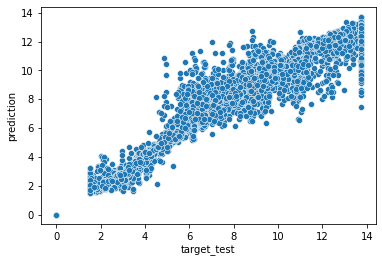

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df1 = pd.DataFrame(target_test)
df2 = pd.DataFrame(prediction)

data = pd.concat([df1, df2], axis=1)
data.columns = ["target_test", "prediction"]

sns.scatterplot(data = data, x = "target_test", y = "prediction")

plt.show()

In [43]:
data["diff"] =  data["target_test"] - data["prediction"]

[(0.0, 600.0)]

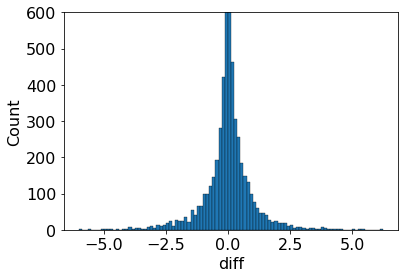

In [98]:
df_mask=((data['diff'] <= -0.25) | (data['diff'] >= 0.25))
#df_mask=(data['diff'] !=0)

filtered_df = data[df_mask]

ax = sns.histplot(data = data
            ,x = 'diff'
            ,alpha = 1
            ,binwidth = 0.125
            
            )
ax.set(ylim=(0, 600))

In [45]:
data["diff"]

0        0.124264
1       -0.660989
2       -1.634851
3        1.414702
4       -1.208420
           ...   
13192    2.220553
13193    1.708007
13194    0.985409
13195   -0.374973
13196    0.463572
Name: diff, Length: 13197, dtype: float64

In [46]:
!pip install statsmodels

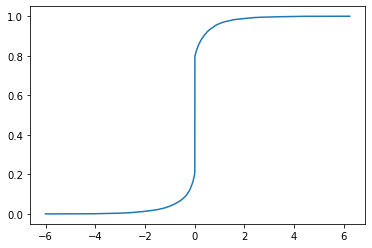

In [47]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
ecdf = ECDF(data["diff"])
plt.plot(ecdf.x, ecdf.y)

In [48]:
data.loc[(data['diff'] >= -0.25) & (data['diff'] <= 0.25), 'class'] = "1"

In [49]:
data["class"] = data["class"].fillna('0')

In [50]:
data["class"].head(10)

0    1
1    0
2    0
3    0
4    0
5    0
6    1
7    0
8    1
9    1
Name: class, dtype: object

In [51]:
test_dropT

array([[ 348. ,  417. ,  442.5, ...,  326. ,  316.5,  336.5],
       [ 426.5,  477. ,  505.5, ...,  449. ,  463. ,  453. ],
       [ 596. ,  746. ,  730.5, ...,  693. ,  714.5,  714. ],
       ...,
       [ 179. ,  179. ,  179. , ...,  179. ,  179. ,  179. ],
       [1043.5, 1003. , 1039. , ..., 1003. , 1003. , 1003. ],
       [   6. ,    6. ,    6. , ...,    6. ,    6. ,    6. ]])

In [52]:
X = test_dropT.transpose() #dataset.iloc[:, 0:4].values
y = data["class"] #dataset.iloc[:, 4].values

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [55]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 509   88]
 [ 183 1860]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       597
           1       0.95      0.91      0.93      2043

    accuracy                           0.90      2640
   macro avg       0.85      0.88      0.86      2640
weighted avg       0.91      0.90      0.90      2640

0.8973484848484848


In [58]:
train_probs = classifier.predict_proba(X_train)[:,1] 
probs = classifier.predict_proba(X_test)[:, 1]
train_predictions = classifier.predict(X_train)

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
#Source: 
#   https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f
#   https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9999958447831252
Test ROC AUC  Score: 0.9510691817711499


f'{metric.capitalize()} 
                 Baseline: {round(baseline[metric], 2)} 
                 Test: {round(results[metric], 2)} 
                 Train: {round(train_results[metric], 2)}
f'{metric.capitalize()} 
                 Baseline: {round(baseline[metric], 2)} 
                 Test: {round(results[metric], 2)} 
                 Train: {round(train_results[metric], 2)}
f'{metric.capitalize()} 
                 Baseline: {round(baseline[metric], 2)} 
                 Test: {round(results[metric], 2)} 
                 Train: {round(train_results[metric], 2)}


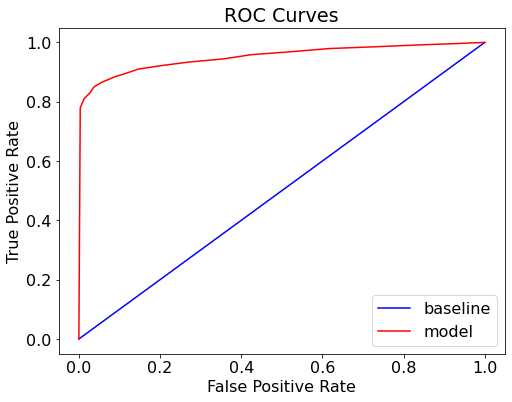

In [90]:
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    y_test = y_test.astype(int)
    y_pred = y_pred.astype(int)
    
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions, pos_label='0')
    train_results['precision'] = precision_score(y_train, train_predictions, pos_label='0')
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:  
          print('''f'{metric.capitalize()} 
                 Baseline: {round(baseline[metric], 2)} 
                 Test: {round(results[metric], 2)} 
                 Train: {round(train_results[metric], 2)}''')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

    
evaluate_model(y_pred, probs, train_predictions, train_probs)


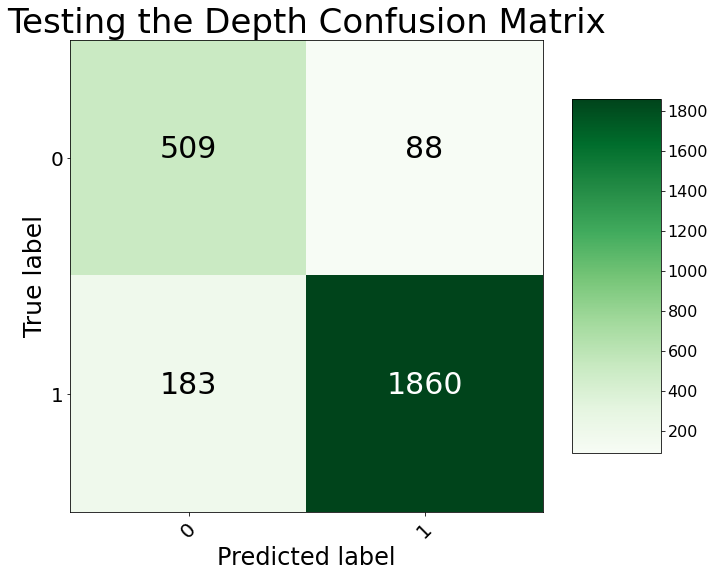

In [88]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 34)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.xticks(tick_marks, classes, rotation=45, size = 20)
    #plt.yticks(tick_marks, classes, size = 14)
    plt.yticks(tick_marks, classes, size = 20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
            #fontsize = 20,
            fontsize = 30,
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        #plt.ylabel('True label', size = 18)
        #plt.xlabel('Predicted label', size = 18)
        plt.ylabel('True label', size = 25)
        plt.xlabel('Predicted label', size = 24)

# Let's plot it out
cm = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm, classes = ['0 - \nHigh Difference', '1 - \nAccepted Depth \nDifference'],
#                      title = 'Testing the Depth Confusion Matrix')
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Testing the Depth Confusion Matrix')

